# Direction finding with compact Volumetric Acoustic Sensor (cVAS)

The following script demonstrates different methods to estimate the direction of sound sources using a comapct volumetric acoustic sensor. Sound sources are simulated to provide the opportunity to assess the quality of the direction estimations.

note to myself: jupyter nbconvert cVAS_direction.ipynb --to html

### Loading libraries
First, some basic libraries are imported and general parameter defined.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import bioacoustic_tools as bat
plt.rc('font', size=15)
#
print(help(bat))

Help on module bioacoustic_tools:

NAME
    bioacoustic_tools

DESCRIPTION
    # %% [markdown]
    # # bioacoustic tools

CLASSES
    builtins.object
        MC

    class MC(builtins.object)
     |  MC(ho, hsel, sv)
     |
     |  Methods defined here:
     |
     |  __init__(self, ho, hsel, sv)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |
     |  __proc_fft__(self, xx, nfft)
     |
     |  __quadInt__(self, uu, imx, nd1)
     |
     |  __str__(self)
     |      Return str(self).
     |
     |  beamform(self, ss, aze, ele, fs, nw, nfft, step=None)
     |
     |  directions(self, ss, fs, nw, step, nfft)
     |
     |  process(self, ss, fs, nw, step, nfft)
     |
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |
     |  __dict__
     |      dictionary for instance variables
     |
     |  __weakref__
     |      list of weak references to the object

FUNCTIONS
    B_path(hd, s

In [2]:
# cVAS hydrophones
ro=0.040 # m
DI,ho,hsel,D,L=bat.getOctahedron(ro)
print(ho)
print(0.75/L,'kHz')


[[ 4.00000000e-02  0.00000000e+00 -2.82842712e-02]
 [-2.00000000e-02  3.46410162e-02 -2.82842712e-02]
 [-2.00000000e-02 -3.46410162e-02 -2.82842712e-02]
 [ 2.00000000e-02  3.46410162e-02  2.82842712e-02]
 [-4.00000000e-02  4.89858720e-18  2.82842712e-02]
 [ 2.00000000e-02 -3.46410162e-02  2.82842712e-02]]
[10.82531755 10.82531755 10.82531755  7.65465545 10.82531755 10.82531755
 10.82531755 10.82531755  7.65465545  7.65465545 10.82531755 10.82531755
 10.82531755 10.82531755 10.82531755] kHz


The print out presents the maximal frequencies that support phase-based operations. Dor 12 pairs the liniting frequency is 10.8 kHz, but for 3 pairs this upper frequency reduces to 7.6 kHz.

### Simulation of cVAS sound reception from a deep source emitting linear frequency modulated (LFM) signal.
The hydrophone measurements are simulated. Here a deep sound source emitting a 5 s LFM signal covering frequencies fro 0 to 24 kHz. The signal was choosen to cover twice the expected maximal bandwidth for coherent processing. As sampling frequency 96 kHz was choosen, to have  multiple samples at the upper boundary of the LFM signal. 

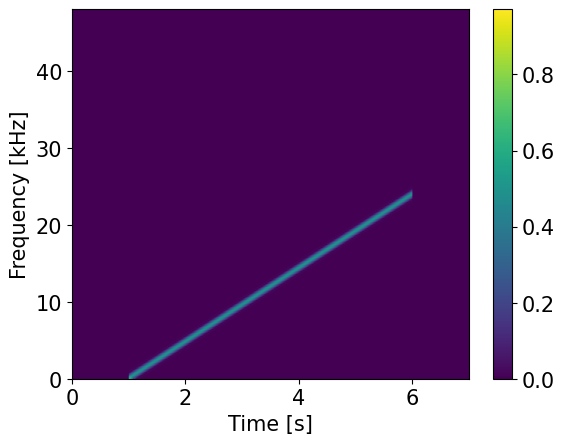

In [3]:
fs=96000
f1=1
f2=24000
t2=5
sso=bat.tonal(fs,1,bat.lfm(f1,f2,t2,fs))
tt=np.arange(sso.shape[0])/fs
ss=np.concatenate((np.zeros(fs),sso,np.zeros(fs)))
ts=np.arange(ss.shape[0])/fs

nw=256
f,t,Q= signal.stft(ss,fs=fs,nperseg=nw,noverlap=nw//2,nfft=2*nw)
#
ext=[t[0],t[-1],f[0]/1000,f[-1]/1000]
plt.imshow(np.abs(Q),aspect='auto',origin='lower',extent=ext)
plt.colorbar()
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.show()


In [4]:
#simulate deep source
az=135*np.pi/180
bd=900 # bottom depth m
hd=500 # hydrophone depth m
sd=800 # source depth m
dx=100 # source distance m

Tx,el,rx=bat.simMultiPath(hd,sd,dx,bd,az,ho,'D')    # Tx ms relative to array center
DS=np.array(Tx)*fs/1000                      # DS samples from acoustic center
print(DS)
#

noise=0.01
xx=bat.array_timeseries(ss,DS,noise)
if 0:
    plt.plot(0.4*xx/xx.max()+np.ones((xx.shape[0],1))*range(xx.shape[1]))
    plt.xlim(95000,105000)
    plt.grid(True)
    plt.show()

[ 1.1448668   2.49925878  1.50777504 -1.50777504 -1.1448668  -2.49925878]


### Direction finding using sound intensity vector
The implementation of the cVAS was diven by the observation that directionality of noise sources is best obtained by using sound intensity, which is a vector quantity. The following algorithm uses the spectrogram to obtain the sound intensity vector.  

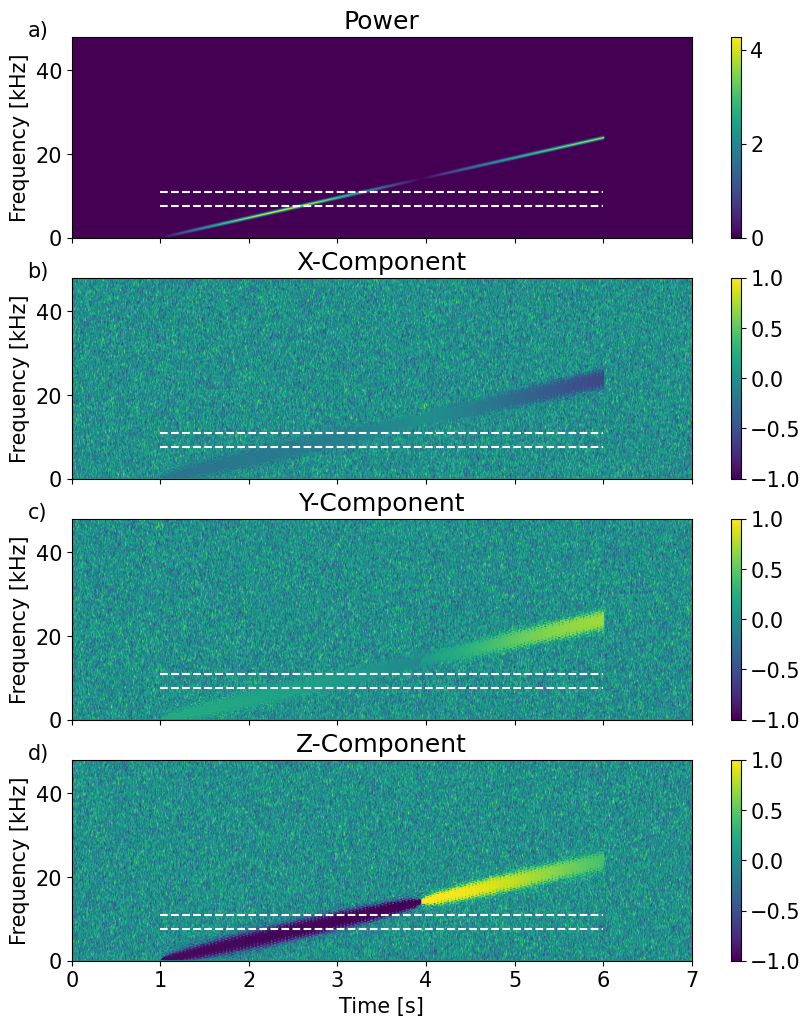

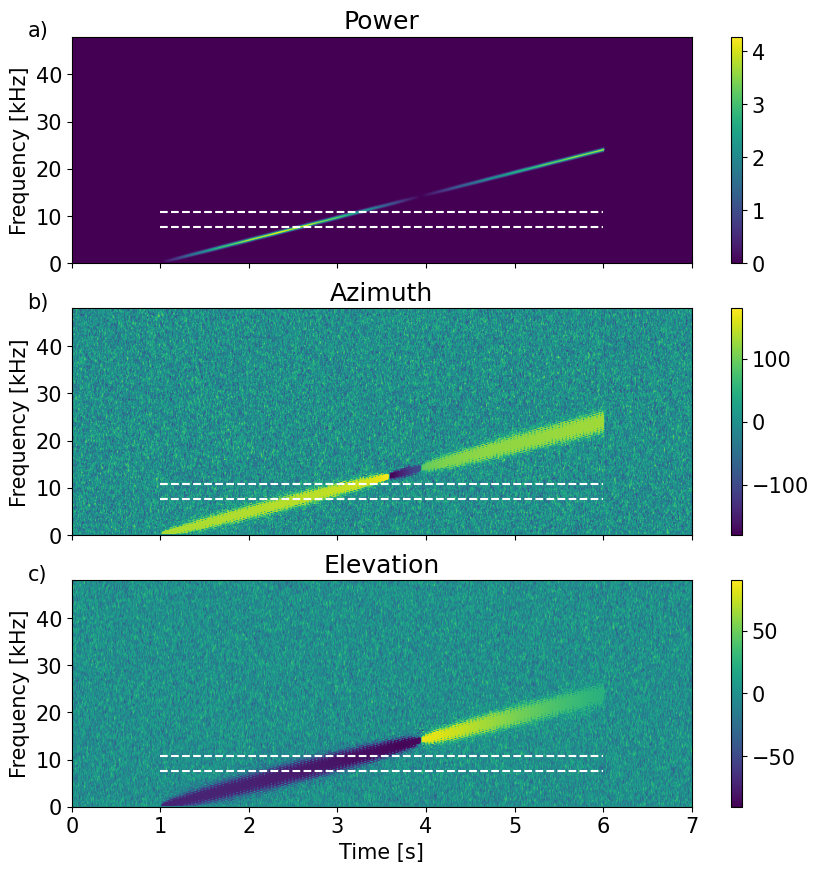

In [5]:
nw=256
nfft=2*nw
a,b,t,f,I = bat.directionFinding(xx,DI,hsel,fs,nw,nfft,method='STFT')
#
In=np.sqrt(np.sum(I**2,-1))
In[ 0,:]=In[ 1,:]
In[-1,:]=In[-2,:]
J=I/In.reshape(In.shape[0],In.shape[1],1)
In[ 0,:]=0
In[-1,:]=0
to=1
ext=(t[0],t[-1],f[0]/1000,f[-1]/1000)

fig, ax = plt.subplots(4, 1, num=0, clear=True, sharex=True, figsize=(10,12))

im=ax[0].imshow(In,origin='lower', aspect='auto',extent=ext)
ax[0].set_title('Power')
plt.colorbar(im)
#
im=ax[1].imshow(J[:,:,0],origin='lower', aspect='auto',extent=ext,clim=(-1,1))
ax[1].set_title('X-Component')
plt.colorbar(im)
#
im=ax[2].imshow(J[:,:,1],origin='lower', aspect='auto',extent=ext,clim=(-1,1))
ax[2].set_title('Y-Component')
plt.colorbar(im)

im=ax[3].imshow(J[:,:,2],origin='lower', aspect='auto',extent=ext,clim=(-1,1))
ax[3].set_xlabel('Time [s]')
ax[3].set_title('Z-Component')
plt.colorbar(im)

if 1:
    for axx in ax:
        axx.set_ylabel('Frequency [kHz]')
        axx.hlines(0.75/np.max(L),to,to+t2,colors='w',linestyles='--')
        axx.hlines(0.75/np.min(L),to,to+t2,colors='w',linestyles='--')

yl=[]
if len(yl)>0:
    for axx in ax:
        axx.set_ylim(yl)

xto=None
xto=-0.5
if xto != None: 
    for axx,itxt in zip(ax,range(ord('a'),ord('a')+len(ax))):
        axx.text(xto,48,chr(itxt)+')')
#
plt.show()


fig, ax = plt.subplots(3, 1, num=0, clear=True, sharex=True, figsize=(10,10))

im=ax[0].imshow(In,origin='lower', aspect='auto',extent=ext)
ax[0].set_title('Power')
plt.colorbar(im)
#
im=ax[1].imshow(a,origin='lower', aspect='auto',extent=ext,clim=(-180,180))
ax[1].set_title('Azimuth')
plt.colorbar(im)
#
im=ax[2].imshow(b,origin='lower', aspect='auto',extent=ext,clim=(-90,90))
ax[2].set_xlabel('Time [s]')
ax[2].set_title('Elevation')
plt.colorbar(im)

if 1:
    for axx in ax:
        axx.set_ylabel('Frequency [kHz]')
        axx.hlines(0.75/np.max(L),to,to+t2,colors='w',linestyles='--')
        axx.hlines(0.75/np.min(L),to,to+t2,colors='w',linestyles='--')

yl=[]
if len(yl)>0:
    for axx in ax:
        axx.set_ylim(yl)

xto=None
xto=-0.5
if xto != None: 
    for axx,itxt in zip(ax,range(ord('a'),ord('a')+len(ax))):
        axx.text(xto,48,chr(itxt)+')')
#
plt.show()


The figure shows the estimated azimuth and elevation angles as function of frequency versus time. The two horizontal dashed lines indicate the two spectral limits where phase-based operations are unique. The lower line considers all hydrophone pairs (including the 3 longer cross-diagonal ones) and the upper line corresonds to the 12 'normal' hydrophone pairs.

### Direction finding using phase differences

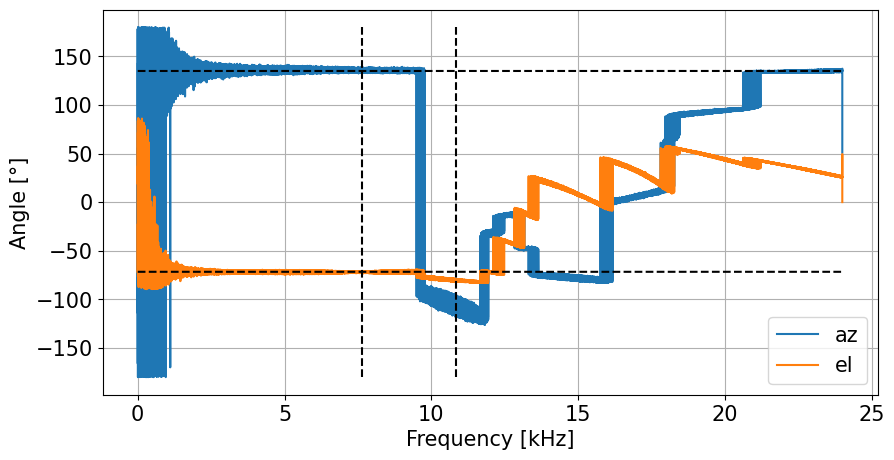

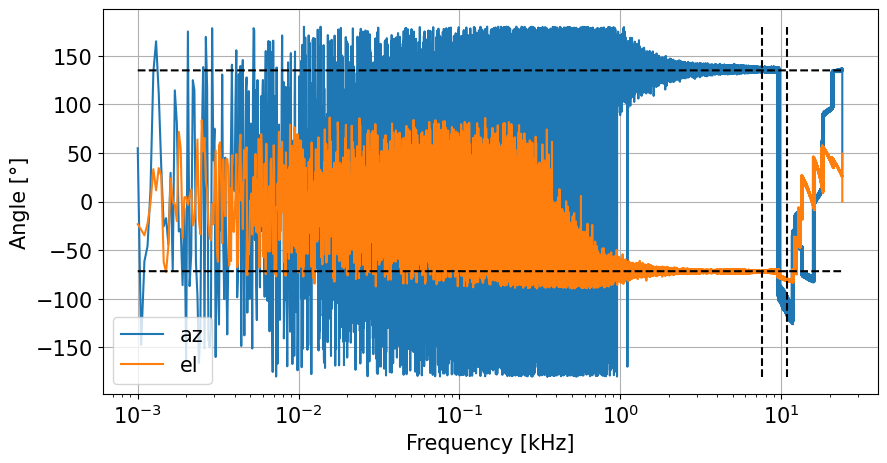

In [6]:
azx,elx,t,f = bat.directionFinding(xx,DI,hsel,fs,method='Phase')

fr=f1+(f2-f1)*tt/t2
ifr=int(to*fs)+np.arange(len(fr),dtype='int')
frk=fr/1000

def Angle_plot(frx,azx,elx,Lm,scale):
    fig = plt.figure("figsize",[10,5])
    plt.plot(frx,azx,label='az')
    plt.plot(frx,elx,label='el')
    plt.plot(frx,180/np.pi*az+0*frx,'k--')
    plt.plot(frx,180/np.pi*el+0*frx,'k--')
    plt.vlines(np.min(Lm),-180,180,colors='k',linestyles='--')
    plt.vlines(np.max(Lm),-180,180,colors='k',linestyles='--')
    #plt.xlim(1e-4,24)
    plt.gca().set_xscale(scale)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('Angle [°]')
    plt.show()


Angle_plot(frk,azx[ifr],elx[ifr],0.75/L,'linear')
Angle_plot(frk,azx[ifr],elx[ifr],0.75/L,'log')


### Direction finding using hydrophone spectrogram based cross correlation

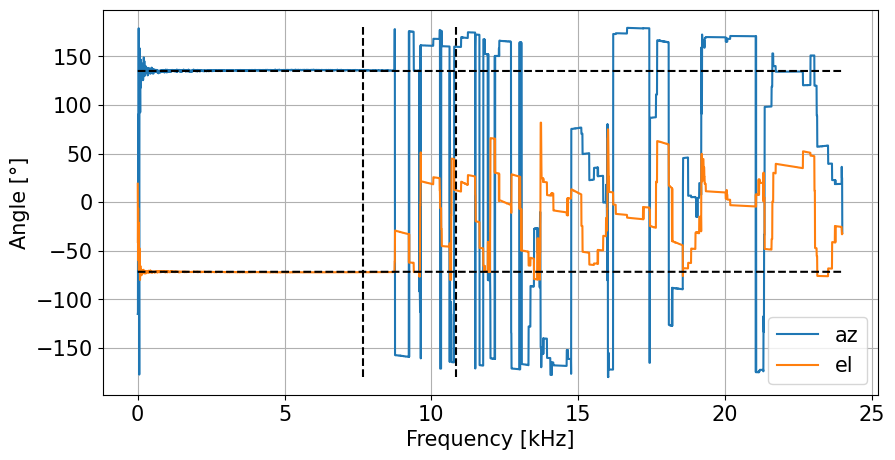

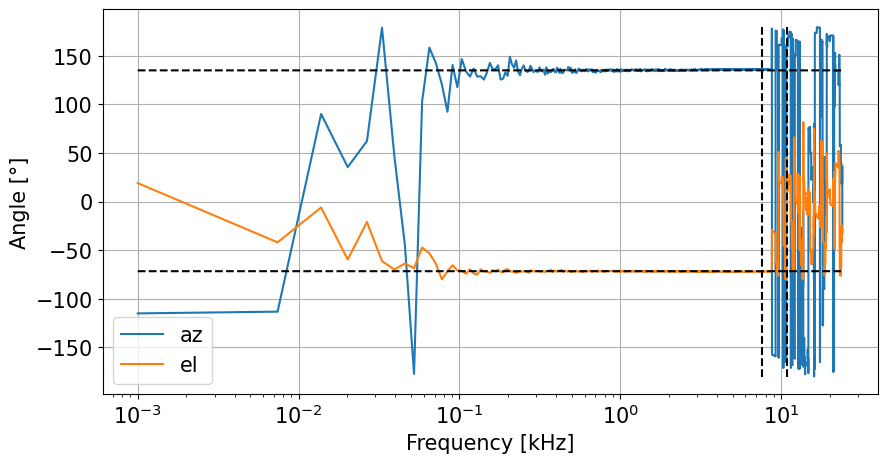

In [7]:
nh=1+int(np.ceil(np.max(L/1500*fs))) 
nw=256
azx,elx,t,f=bat.directionFinding(xx,DI,hsel,fs,nw=nw,nfft=2*nw,nh=nh, method="XCORR")
#
nstep=nw//2
fx=np.zeros(ss.shape[0])
fx[:int(to*fs)]=np.nan
fx[int(to*fs):int((to+t2)*fs)]=fr
fx[int((to+t2)*fs):]=np.nan
fx1=fx[::nstep]

ifr=np.where(~np.isnan(fx1))
frk=fx1[ifr]/1000

Angle_plot(frk,azx[ifr],elx[ifr],0.75/L,'linear')
Angle_plot(frk,azx[ifr],elx[ifr],0.75/L,'log')


### Direction finding using time-delay-of-arrival (tdoa) of matched filtered data


As the signal is simulated as a linear frequency modulated time series, it is appropriate to pre-process the data using a matched filter to compress the signal into sharp transients. Using these shortened signals, standard time-delay-of arrival (tdoa) methods can be applied to obtain the direction of the sound source.

135.2581791112572 -71.19157128013923
[135.         -71.56505118]


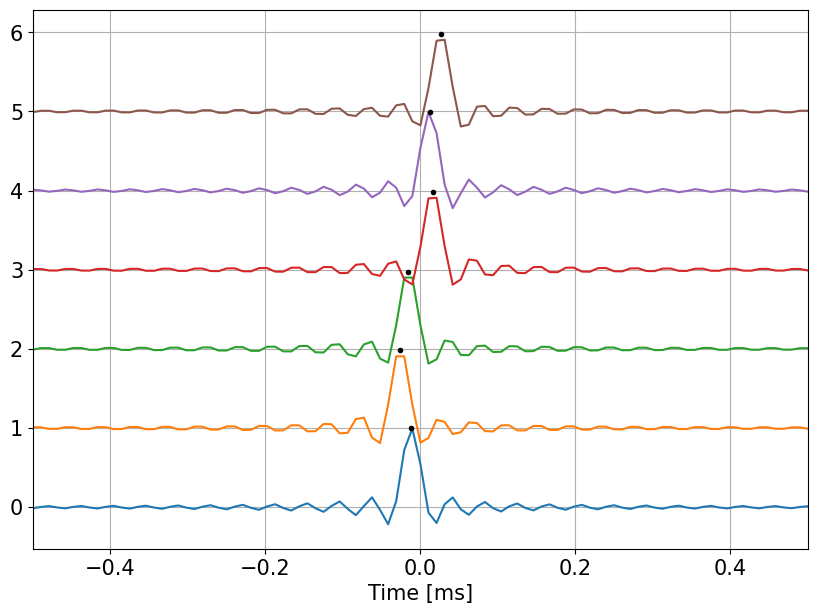

In [8]:
# matched filter of generated signal
zz=bat.matched_filt(sso,xx)

azx,elx,t,f,ux=bat.directionFinding(zz,DI,hsel,fs,method="TDOA_0")

print(azx,elx)
print(np.array([az,el])*180/np.pi)

tux=ux[:,0]/fs

n1,n2=zz.shape
n3=ux.shape[0]

plt.figure(figsize=(10,7))
plt.plot((ts-np.mean(tux))*1000,zz+np.ones((n1,1))*range(n2))
plt.plot((tux-np.mean(tux))*1000,ux[:,1]+np.arange(n3),'k.')
plt.xlim(-0.5,0.5)
plt.grid(True)
plt.xlabel('Time [ms]')
plt.show()


The figure shows the output of the matched filter for all hydrophones and the time delays are clearly visible. For each of the transient the time of the maximum was obtained by quadratic interpolation of 3 relevant samples. The estimated sound direction (azimuth and elevation)  are very close to the simulated one.

## Beamformer
Knowing, or assuming the arrival angles of the sound, a beamformer takes the delayed time series of the array, correct for the delays and generates an average time series.

135.2581791112572 -71.19157128013923


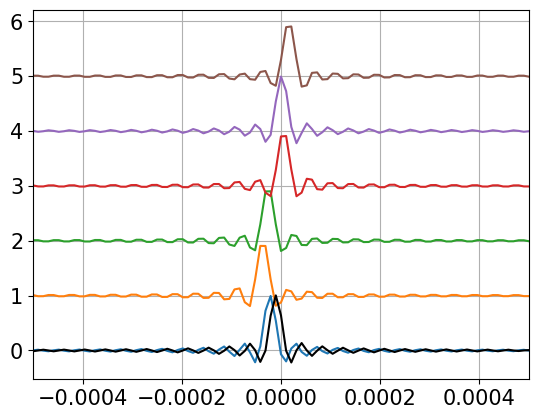

In [9]:
aze=azx
ele=elx
print(aze,ele)

sv=1500
mc=bat.MC(ho,hsel,sv)
#

nw=256
nstep=128
nfft=512
uu = mc.beamform(zz,aze,ele,fs,nw,nfft)     # long time series


#def stack(x): return x+np.ones((x.shape[0],1))*range(x.shape[1])
tso=3.5
plt.plot(ts-tso,bat.stack(zz))

plt.plot(ts-tso,uu,'k')
plt.grid(True)
plt.xlim(-0.0005,0.0005)
plt.show()


In the following a short snippet is extracted from the measurements and the arrival angles are used to line-up (beamform) the data.

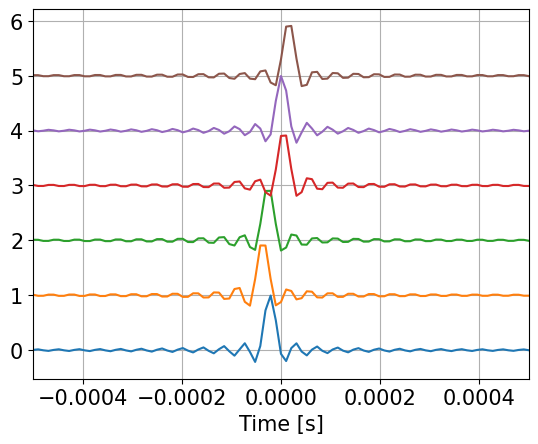

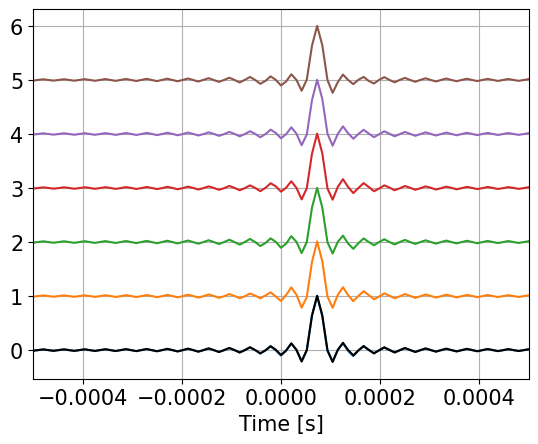

In [10]:
io=int(3.5*fs)-128
zzz=zz[io:io+256,:]
plt.plot(np.arange(-128,128)/fs,bat.stack(zzz))
plt.xlabel('Time [s]')
plt.xlim(-5e-4,5e-4)
plt.grid(True)
plt.show()

uu,uuo=mc.beamform(zzz,aze,ele,fs,nw,nfft,0) # signle data snippet

plt.plot(np.arange(-128,128)/fs,bat.stack(uuo))
plt.plot(np.arange(-128,128)/fs,uu,'k')
plt.xlabel('Time [s]')
plt.xlim(-5e-4,5e-4)
plt.grid(True)
plt.show()
